# Experiment 1 - GP Classification and Logistic Regression

Here, we will compare the performance of two GP classification methods (Laplace approximation, variational inferrence) and logistic regression on a benchmark dataset obtained from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets). In particular, we will consider the diagnostic [Wisconsin Breast Cancer Dataset](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29).

## Setup

In [3]:
#Importing libraries

#Basic libraries

%pylab inline
import time
import numpy as np
import pandas as pd
import matplotlib;matplotlib.rcParams['figure.figsize']=(10,6)
from matplotlib import pyplot as plt
import seaborn as sns

#For GP models

import GPy
from scipy import optimize

#For logistic regression 

from statsmodels.tools import add_constant
import statsmodels.api as sm
from scipy.special import expit, logit

#Libraries for importing data files

import sys
import os

ROOT = os.path.dirname(os.getcwd())
sys.path.append(os.path.join(ROOT, 'Data'))


Populating the interactive namespace from numpy and matplotlib


In [2]:
#Configuring plot styles

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
#import matplotlib;matplotlib.rcParams['text.usetex'] = True
import matplotlib;matplotlib.rcParams['font.size'] = 16
import matplotlib;matplotlib.rcParams['font.family'] = 'serif'

## Importing Dataset

For our dataset, features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image.

The features are:

1. Radius (mean of distances from center to points on the perimeter)
2. Texture (standard deviation of gray-scale values)
3. Perimeter
4. Area
5. Smoothness (local variation in radius lengths)
6. Compactness (perimeter^2 / area - 1.0)
7. Concavity (severity of concave portions of the contour)
8. Concave points (number of concave portions of the contour)
9. Symmetry 
10. Fractal dimension ("coastline approximation" - 1)

The mean, standard error, and "worst" or largest (mean of the three largest values) of these features were computed for each image, resulting in 30 features.  For instance, field 3 is Mean Radius, field 13 is Radius SE, field 23 is Worst Radius.

In [4]:
#Writing column names

col_names = ["id", "diagnosis","radius_mean", "texture_mean", "perimeter_mean", "area_mean", "smoothness_mean", 
"compactness_mean", "concavity_mean", "concave_points_mean", "symmetry_mean", "fractal_dimension_mean", 
"radius_se", "texture_se", "perimeter_se",  "area_se", "smoothness_se", "compactness_se",  
"concavity_se", "concave_points_se", "symmetry_se", "fractal_dimension_se", "radius_worst", 
"texture_worst", "perimeter_worst",  "area_worst", "smoothness_worst", "compactness_worst",  "concavity_worst", 
"concave_points_worst", "symmetry_worst", "fractal_dimension_worst"]
print(len(col_names))

32


In [5]:
#Importing dataset

path_data = os.path.join(ROOT, 'Data')
sys.path.insert(0, ROOT)

filename = os.path.join(path_data,'wdbc.data')
df = pd.read_csv(filename)

#Changing column names

df.columns = col_names
df.head(3)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
1,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
2,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300


## Data-Preprocessing

In [6]:
#Data pre-procesing

df.drop(labels="id", axis=1, inplace=True)   #dropping id column

#Converting diagnosis to binary outcomes

binary_encoder = {'M':1, 'B':0}
df["diagnosis"] = df["diagnosis"].map(binary_encoder)
df.head(3)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
1,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
2,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300


In [9]:
#No of rows with at least one null value

perm = df.isna().any(axis=1)
no_null = df[perm].index.size
print(f'No. of rows with null values: {no_null}')

No. of rows with null values: 0


## Explanatory Analysis

### Summary Statistics

In [ ]:
#Info on data set

df.info()

In [9]:
#Describing dataset

df.describe()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
count,568.000000,568.000000,568.000000,568.000000,568.000000,568.000000,568.000000,568.000000,568.000000,568.000000,...,568.00000,568.000000,568.000000,568.000000,568.000000,568.000000,568.000000,568.000000,568.000000,568.000000
mean,0.371479,14.120491,19.305335,91.914754,654.279754,0.096321,0.104036,0.088427,0.048746,0.181055,...,16.25315,25.691919,107.125053,878.578873,0.132316,0.253541,0.271414,0.114341,0.289776,0.083884
std,0.483626,3.523416,4.288506,24.285848,351.923751,0.014046,0.052355,0.079294,0.038617,0.027319,...,4.82232,6.141662,33.474687,567.846267,0.022818,0.156523,0.207989,0.065484,0.061508,0.018017
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.93000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,0.000000,11.697500,16.177500,75.135000,420.175000,0.086290,0.064815,0.029540,0.020310,0.161900,...,13.01000,21.095000,84.102500,514.975000,0.116600,0.146900,0.114475,0.064730,0.250350,0.071412
50%,0.000000,13.355000,18.855000,86.210000,548.750000,0.095865,0.092525,0.061400,0.033455,0.179200,...,14.96500,25.425000,97.655000,685.550000,0.131300,0.211850,0.226550,0.099840,0.282050,0.080015
75%,1.000000,15.780000,21.802500,103.875000,782.625000,0.105300,0.130400,0.129650,0.073730,0.195625,...,18.76750,29.757500,125.175000,1073.500000,0.146000,0.337600,0.381400,0.161325,0.317675,0.092065
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.04000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [ ]:
#Mean of features w.r.t. diagnosis outcomes

grouped_stats = df.groupby('diagnosis').mean()
grouped_stats

In [11]:
#Histogram of outcome variables

#Getting counts

outcome_count = df["diagnosis"].value_counts()
outcome_count = pd.Series(outcome_count)
outcome_count = pd.DataFrame(outcome_count)
outcome_count.index = ['Benign', 'Malignant']
outcome_count

outcome_count['Percent'] = 100*outcome_count['diagnosis']/sum(outcome_count['diagnosis'])
outcome_count['Percent'] = outcome_count['Percent'].round().astype('int')
outcome_count.columns = ["Diagnosis", "Percent"]

outcome_count

,Diagnosis,Percent
Benign,357,63
Malignant,211,37


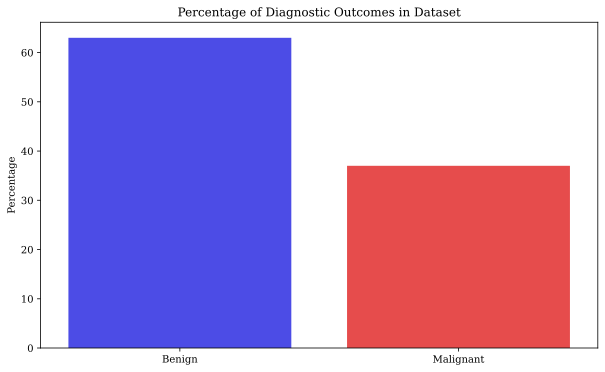

In [12]:
#Plotting histogram of counts

sns.barplot(x = ['Benign', 'Malignant'], y = 'Percent', data = outcome_count, alpha = .8, palette=["Blue", "Red"])
plt.title('Percentage of Diagnostic Outcomes in Dataset')
plt.ylabel('Percentage')
plt.show()

### Visualizations

#### Pairs plots

In [ ]:
#Pairs plot of features

#Full pairs plot is computationall intensive so can instead do 3 10x10 plots

indices = [list(range(11)), [0]+list(range(11,21)), [0]+list(range(21,31))]

fig = plt.figure(figsize=(6,4))
sns.pairplot(df.iloc[:,indices[0]], hue="diagnosis")
plt.title("Pairs plot of feature means")
plt.savefig("Pairs plot of means", dpi=fig.dpi)
plt.show()

In [ ]:
#Further pairs plot of features ses

fig = plt.figure(figsize=(6,4))
sns.pairplot(df.iloc[:,indices[1]], hue="diagnosis")
plt.title("Pairs plot of feature standard errors")
plt.savefig("Pairs plot of ses", dpi=fig.dpi)
plt.show()


In [ ]:
#Further pairs plot of features worsts

fig = plt.figure(figsize=(6,4))
sns.pairplot(df.iloc[:,indices[2]], hue="diagnosis")
plt.title("Pairs plot of feature worsts")
plt.savefig("Pairs plot of worst", dpi=fig.dpi)
plt.show()


#### Correlations

In [8]:
#Finding features with correlation greater tha 0.9

corr_matrix = df.iloc[:,1:].corr().abs()
high_corr_var = np.where(corr_matrix > 0.90)
high_corr_var=[(corr_matrix.columns[x], corr_matrix.columns[y]) for x, y in zip(*high_corr_var) if (x!=y and x<y)]
high_corr_var

[('radius_mean', 'perimeter_mean'),
 ('radius_mean', 'area_mean'),
 ('radius_mean', 'radius_worst'),
 ('radius_mean', 'perimeter_worst'),
 ('radius_mean', 'area_worst'),
 ('texture_mean', 'texture_worst'),
 ('perimeter_mean', 'area_mean'),
 ('perimeter_mean', 'radius_worst'),
 ('perimeter_mean', 'perimeter_worst'),
 ('perimeter_mean', 'area_worst'),
 ('area_mean', 'radius_worst'),
 ('area_mean', 'perimeter_worst'),
 ('area_mean', 'area_worst'),
 ('concavity_mean', 'concave_points_mean'),
 ('concave_points_mean', 'concave_points_worst'),
 ('radius_se', 'perimeter_se'),
 ('radius_se', 'area_se'),
 ('perimeter_se', 'area_se'),
 ('radius_worst', 'perimeter_worst'),
 ('radius_worst', 'area_worst'),
 ('perimeter_worst', 'area_worst')]

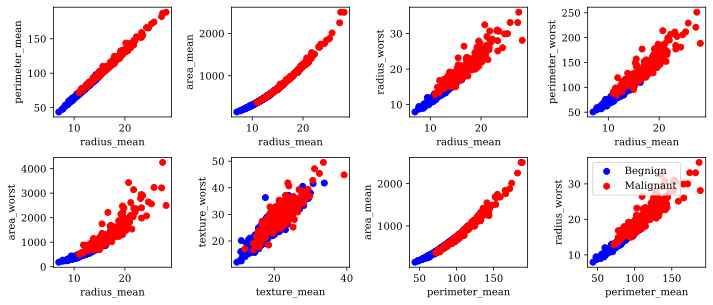

In [23]:
#Pairs plot of correlated features to guide feature removal

#Splitting df into two class groups for ease of plotting and later usage

df_b = df[df['diagnosis'] == 0]
df_m = df[df['diagnosis'] == 1]

fig = plt.figure()

# Create 'for loop' to enerate though tumor features and compare with histograms
for i,b in enumerate(high_corr_var[0:8]):
    
    # Enumerate starts at index 0, need to add 1 for subplotting
    i +=1
    
    # Create axes object for position i
    ax = fig.add_subplot(3,4,i)
    
    # Pairs plot
    
    plt.scatter(df_b[b[0]], df_b[b[1]], c="Blue", label="Begnign")
    plt.scatter(df_m[b[0]], df_m[b[1]], c="Red", label="Malignant")
    
    ax.set_xlabel(b[0])
    ax.set_ylabel(b[1])
    #ax.set_title(f"{b[0]} vs. {b[1]}")

plt.tight_layout()
plt.legend(loc="best")
plt.savefig("Pairs plot of correlated features 1", dpi=fig.dpi)
plt.show()

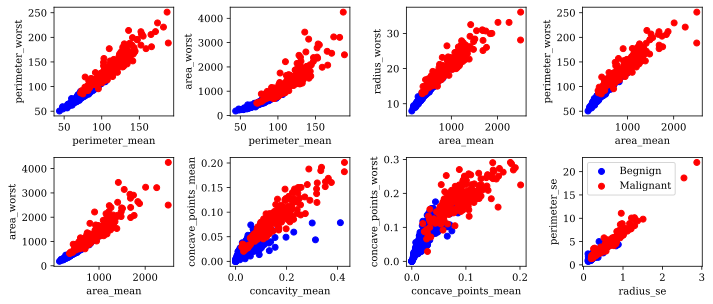

In [25]:
#Further pairs plot

fig = plt.figure()

# Create 'for loop' to enerate though tumor features and compare with histograms
for i,b in enumerate(high_corr_var[8:16]):
    
    # Enumerate starts at index 0, need to add 1 for subplotting
    i +=1
    
    # Create axes object for position i
    ax = fig.add_subplot(3,4,i)
    
    # Pairs plot
    
    plt.scatter(df_b[b[0]], df_b[b[1]], c="Blue", label="Begnign")
    plt.scatter(df_m[b[0]], df_m[b[1]], c="Red", label="Malignant")
    
    ax.set_xlabel(b[0])
    ax.set_ylabel(b[1])
    #ax.set_title(f"{b[0]} vs. {b[1]}")

plt.tight_layout()
plt.legend(loc="best")
plt.savefig("Pairs plot of correlated features 2", dpi=fig.dpi)
plt.show()

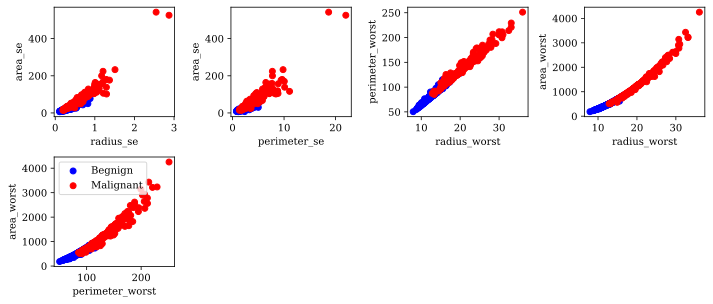

In [26]:
#Further pairs plot

fig = plt.figure()

# Create 'for loop' to enerate though tumor features and compare with histograms
for i,b in enumerate(high_corr_var[16:]):
    
    # Enumerate starts at index 0, need to add 1 for subplotting
    i +=1
    
    # Create axes object for position i
    ax = fig.add_subplot(3,4,i)
    
    # Pairs plot
    
    plt.scatter(df_b[b[0]], df_b[b[1]], c="Blue", label="Begnign")
    plt.scatter(df_m[b[0]], df_m[b[1]], c="Red", label="Malignant")
    
    ax.set_xlabel(b[0])
    ax.set_ylabel(b[1])
    #ax.set_title(f"{b[0]} vs. {b[1]}")

plt.tight_layout()
plt.legend(loc="best")
plt.savefig("Pairs plot of correlated features 3", dpi=fig.dpi)
plt.show()

In [27]:
#Highly correlated features to remove bsaed on above

corr_features = set(map(lambda x: x[0], high_corr_var))
corr_features = list(corr_features)
corr_features

['perimeter_mean',
 'area_mean',
 'concave_points_mean',
 'radius_mean',
 'radius_se',
 'perimeter_worst',
 'texture_mean',
 'radius_worst',
 'concavity_mean',
 'perimeter_se']

#### Heatmap

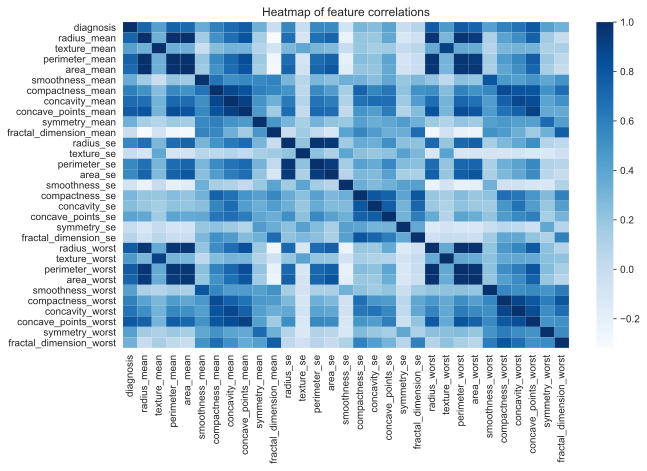

In [49]:
#Visualization of relationships between features and diagnoses

sns.heatmap(df.corr(), cmap="Blues")
sns.set_style("whitegrid")
plt.title("Heatmap of feature correlations")
plt.savefig("Heatmap of feature correlations ", dpi=fig.dpi)
plt.show()

#### Distribution of features for benign and malignant

Here, we will look at the distribution of features for the two classes. This, as well as above plots, can be used for guidance for feature selection via statistical inspection.

In [67]:
df_b = df[df['diagnosis'] == 0]
df_m = df[df['diagnosis'] == 1]
#df_m.drop(labels="diagnosis", axis=1, inplace=True)   #dropping daginosis column
#df_b.drop(labels="diagnosis", axis=1, inplace=True)   #dropping daginosis column

For the below plot, we see that the following features best discriminate between the classes:  radius_mean, texture_mean, perimeter_mean, compactness_mean, concavity_mean, concave_points_mean.

The rest of the features have the distributions for the classes heavily superimosed on each other, indicating that they discriminate poorly between the classes.

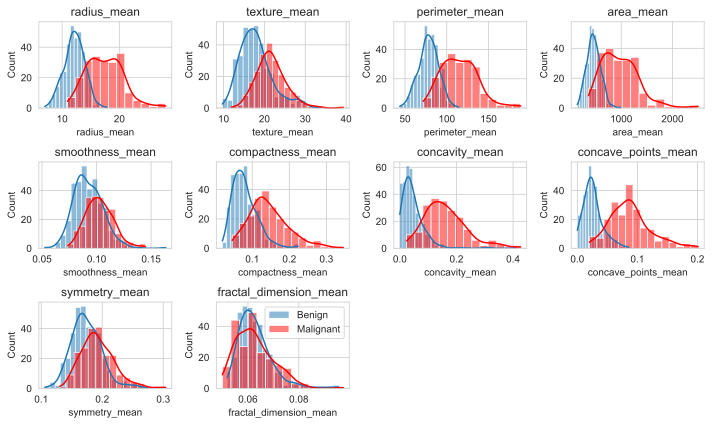

In [80]:
fig = plt.figure()

# Create 'for loop' to enerate though tumor features and compare with histograms
for i,b in enumerate(list(df.columns[1:11])):
    
    # Enumerate starts at index 0, need to add 1 for subplotting
    i +=1
    
    # Create axes object for position i
    ax = fig.add_subplot(3,4,i)
    
    # Plot via histogram tumor charateristics using stacked and alpha parameters for..
    # comparisons.
    sns.histplot(df_b[b], kde=True, label='Benign')
    sns.histplot(df_m[b], kde=True, label='Malignant', color="Red")
    
    ax.set_title(b)

sns.set_style("whitegrid")
plt.tight_layout()
plt.legend()
plt.savefig("Distribution of mean features for outcomes", dpi=fig.dpi)
plt.show()

For the below plot, we see that the following features best discriminate between the classes:  compactness_se, concavity_se, concave_points_se.

The rest of the features have the distributions for the classes heavily superimosed on each other, indicating that they discriminate poorly between the classes.

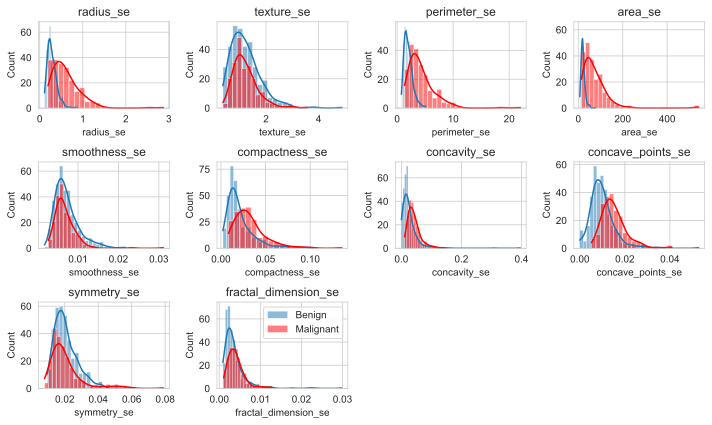

In [81]:
fig = plt.figure()

# Create 'for loop' to enerate though tumor features and compare with histograms
for i,b in enumerate(list(df.columns[11:21])):
    
    # Enumerate starts at index 0, need to add 1 for subplotting
    i +=1
    
    # Create axes object for position i
    ax = fig.add_subplot(3,4,i)
    
    # Plot via histogram tumor charateristics using stacked and alpha parameters for..
    # comparisons.
    sns.histplot(df_b[b], kde=True, label='Benign')
    sns.histplot(df_m[b], kde=True, label='Malignant', color="Red")
    
    ax.set_title(b)

sns.set_style("whitegrid")
plt.tight_layout()
plt.legend()
plt.savefig("Distribution of se features for outcomes", dpi=fig.dpi)
plt.show()

For the below plot, we see that the following features best discriminate between the classes:  radius_worst, texture_worst, perimeter_worst, area_worst, compactness_worst, concavity_worst, concave_points_worst.

The rest of the features have the distributions for the classes heavily superimosed on each other, indicating that they discriminate poorly between the classes.

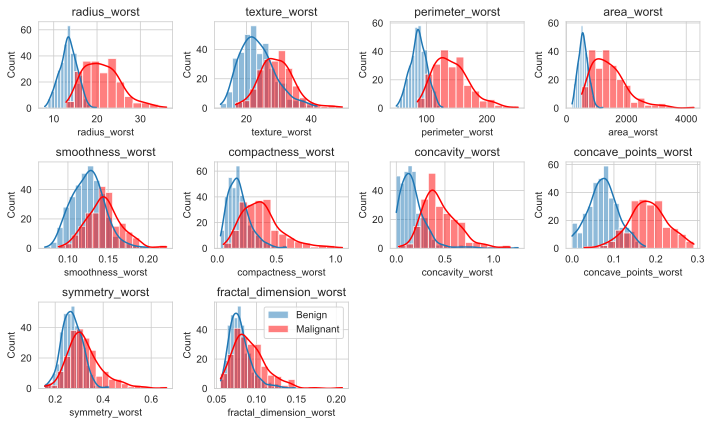

In [82]:
fig = plt.figure()

# Create 'for loop' to enerate though tumor features and compare with histograms
for i,b in enumerate(list(df.columns[21:])):
    
    # Enumerate starts at index 0, need to add 1 for subplotting
    i +=1
    
    # Create axes object for position i
    ax = fig.add_subplot(3,4,i)
    
    # Plot via histogram tumor charateristics using stacked and alpha parameters for..
    # comparisons.
    sns.histplot(df_b[b], kde=True, label='Benign')
    sns.histplot(df_m[b], kde=True, label='Malignant', color="Red")
    
    ax.set_title(b)

sns.set_style("whitegrid")
plt.tight_layout()
plt.legend()
plt.savefig("Distribution of worst features for outcomes", dpi=fig.dpi)
plt.show()

## Model fitting without correlated features

### Train-test split

In [34]:
#Removing highly correlated features

df.drop(labels=corr_features, axis=1, inplace=True)


#Splitting into test-train split with 0.8 training set

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,1:], df['diagnosis'], train_size = .8, random_state = 42)

#Resetting indices

X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True, inplace=True)

#No scaling/normalizing of data required as models are not influenced by scale
#This may be recosindered in the future


In [36]:
#Modifying into arrays for models

X_train_arr = X_train.values
X_test_arr = X_test.values
y_train_arr = y_train.values.reshape(y_train.shape[0], 1)
y_test_arr = y_test.values.reshape(y_test.shape[0], 1)

### Variational GP Classification

#### Sparse Varational GP Classification

In [37]:
#For this method we require inducing input points, Z
#We will choose 10% of training size as inducing input points.

n = int(0.1*y_train.size)

#Choosing n random points from training set as inducing points to be optimized

np.random.seed(42)
points = np.random.randint(low=0, high=y_train.size, size=n)
Z_train = X_train.iloc[points,:]
Z_train_arr = Z_train.values

print(f'No. inducing points: {n}')

No. inducing points: 45


In [40]:
#Creating sparse varational GP classification model

m_sparse_GP = GPy.core.SVGP(X_train_arr, y_train_arr, kernel=GPy.kern.RBF(20)+GPy.kern.White(20), likelihood=GPy.likelihoods.Bernoulli(), Z=Z_train_arr)

In [41]:
#Optimizing model

comp_times = pd.Series({"GP_var_sparse": 0, "GP_full_var": 0, "GP_Laplace": 0, "Logistic_reg": 0})   #Computatin times

t0 = time.time()
m_sparse_GP.optimize('bfgs')
t1 = time.time()

comp_times["GP_var_sparse"] = t1-t0

In [42]:
#Model output

m_sparse_GP

SVGP.,value,constraints,priors
inducing inputs,"(45, 20)",,
sum.rbf.variance,4.1987127084373515e-07,+ve,
sum.rbf.lengthscale,1.0558223951172452,+ve,
sum.white.variance,2.116237545153743e-07,+ve,
q_u_chol,"(1035, 1)",,
q_u_mean,"(45, 1)",,


In [43]:
#Predictons

predict_sparse_var = m_sparse_GP.predict(X_test_arr)[0]
classification_sparse_var = np.where(predict_sparse_var >= 0.5, 1, 0)
CRR_sparse_var = np.where(classification_sparse_var == y_test_arr)[0].size/y_test_arr.size    #corect classification rate
CRR_sparse_var

0.47368421052631576

#### Full Variational GP Classification

In [45]:
#Creating full GP model without sparse approximations

m_full_GP = GPy.models.GPVariationalGaussianApproximation(X_train_arr, y_train_arr, kernel=GPy.kern.RBF(20)+GPy.kern.White(20), likelihood=GPy.likelihoods.Bernoulli())

In [46]:
#Optimizing model

t0 = time.time()
m_full_GP.optimize('bfgs')
t1 = time.time()

comp_times["GP_var_full"] = t1-t0

In [47]:
#Model output

m_full_GP

VarGP.,value,constraints,priors
sum.rbf.variance,4.5460764855793707e-08,+ve,
sum.rbf.lengthscale,1.167568590200493,+ve,
sum.white.variance,4.4650055638121245e-08,+ve,
alpha,"(454, 1)",,
beta,"(454,)",,


In [48]:
#Predictons

predict_full_var = m_full_GP.predict(X_test_arr)[0]
classification_full_var = np.where(predict_full_var >= 0.5, 1, 0)
CRR_full_var = np.where(classification_full_var == y_test_arr)[0].size/y_test_arr.size    #corect classification rate
CRR_full_var

0.7017543859649122

#### Laplacian GP Classification

In [51]:
#Creating Laplacian inference model

lik = GPy.likelihoods.Bernoulli()    #Bernoulli likelihood
kl = GPy.kern.RBF(20, variance=1., lengthscale=1)        #Kernel with specific legnthscale and variance, both set to units
laplace_inf = GPy.inference.latent_function_inference.Laplace()
m_laplace_GP = GPy.core.GP(X=X_train_arr,
                Y=y_train_arr, 
                kernel=kl, 
                inference_method=laplace_inf,
                likelihood=lik)


In [52]:
#Optimizing  model

t0= time.time()
m_laplace_GP.optimize('bfgs', max_iters=100)
t1 = time.time()

comp_times["GP_Laplace"] = t1-t0

In [53]:
#Model output

m_laplace_GP

gp.,value,constraints,priors
rbf.variance,7289.567377457851,+ve,
rbf.lengthscale,1312.8230386579553,+ve,


In [54]:
#Predictons

predict_laplace = m_laplace_GP.predict(X_test_arr)[0]
classification_laplace = np.where(predict_laplace >= 0.5, 1, 0)
CRR_laplace = np.where(classification_laplace == y_test_arr)[0].size/y_test_arr.size    #corect classification rate
CRR_laplace


0.8947368421052632

#### Logistic Regression

In [58]:
#Fitting logistic regression model with logit link, including intercept term

X_train_design = add_constant(X_train_arr)

t0 = time.time()
m_log_r = sm.Logit(y_train_arr, X_train_design).fit(method="bfgs")
t1 = time.time()

comp_times["Logistic_reg"] = t1-t0

         Current function value: 0.074824
         Iterations: 35
         Function evaluations: 46
         Gradient evaluations: 39


 c:\users\ashou\anaconda3\envs\gp_project\lib\site-packages\statsmodels\discrete\discrete_model.py:1799: RuntimeWarning:overflow encountered in exp
 c:\users\ashou\anaconda3\envs\gp_project\lib\site-packages\statsmodels\discrete\discrete_model.py:1852: RuntimeWarning:divide by zero encountered in log
 c:\users\ashou\anaconda3\envs\gp_project\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


In [59]:
#Model summary

m_log_r.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  454
Model:                          Logit   Df Residuals:                      433
Method:                           MLE   Df Model:                           20
Date:                Thu, 17 Dec 2020   Pseudo R-squ.:                  0.8858
Time:                        09:11:54   Log-Likelihood:                -33.970
converged:                      False   LL-Null:                       -297.54
Covariance Type:            nonrobust   LLR p-value:                 5.988e-99
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -23.0194     12.087     -1.904      0.057     -46.710       0.672
x1            -1.4860     83.930     -0.018      0.986    -165.985     163.013
x2             0.5192     37.799      0.014      0.989     -73.566      74.605
x3            -2.9362     31.894     -0.092      0.927     -65.448      59.575
x4            -1.2866    251.293     -0.005      0.996    -493.811     491.238
x5            -3.9359      1.584     -2.485      0.013      -7.040      -0.832
x6             0.1316      0.051      2.569      0.010       0.031       0.232
x7            -0.0908    349.767     -0.000      1.000    -685.621     685.439
x8            -0.1335    139.224     -0.001      0.999    -273.008     272.741
x9            -0.1443     58.133     -0.002      0.998    -114.082     113.794
x10           -0.0702    318.293     -0.000      1.000    -623.913     623.772
x11           -0.4334    110.306     -0.004      0.997    -216.629     215.762
x12           -0.0763    526.019     -0.000      1.000   -1031.055    1030.903
x13            0.4026      0.122      3.291      0.001       0.163       0.642
x14            0.0122      0.005      2.551      0.011       0.003       0.022
x15           -1.2628     61.516     -0.021      0.984    -121.833     119.307
x16            4.7034     19.391      0.243      0.808     -33.301      42.708
x17            8.0851     10.457      0.773      0.439     -12.409      28.580
x18            2.1642     30.685      0.071      0.944     -57.978      62.307
x19           -2.8545     17.933     -0.159      0.874     -38.002      32.293
x20           -0.9095     93.982     -0.010      0.992    -185.111     183.292
==============================================================================

Possibly complete quasi-separation: A fraction 0.47 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [61]:
#Making predictions of latent probabilities

X_test_design = add_constant(X_test_arr)

predict_log_r = m_log_r.predict(X_test_design).reshape(114,1)
classification_log_r = np.where(predict_log_r >= 0.5, 1, 0)
CRR_log_r = np.where(classification_log_r == y_test_arr)[0].size/y_test_arr.size    #corect classification rate
CRR_log_r

0.9298245614035088

## Results

### Classification Rates

In [62]:
#Classification rates

CRRs = {"GP_full_var": CRR_full_var, "GP_sparse_var": CRR_sparse_var, 
       "GP_Laplace": CRR_laplace, "Logistic regression": CRR_log_r}
CRRs = pd.Series(CRRs)
CRRs

GP_full_var            0.701754
GP_sparse_var          0.473684
GP_Laplace             0.894737
Logistic regression    0.929825
dtype: float64

### ROC Curves and AUCs

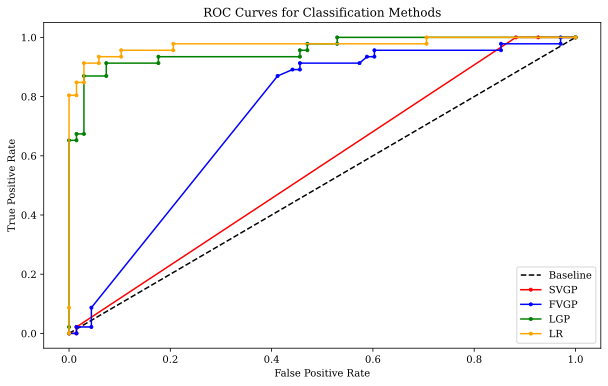

In [65]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

#ROC Curves

sparse_var_fpr, sparse_var_tpr, thresholds = roc_curve(y_test_arr, predict_sparse_var)
full_var_fpr, full_var_tpr, thresholds = roc_curve(y_test_arr, predict_full_var)
GP_laplace_fpr, GP_laplace_tpr, thresholds = roc_curve(y_test_arr, predict_laplace)
log_r_fpr, log_r_tpr, thresholds = roc_curve(y_test_arr, predict_log_r)

plt.plot([0,1], [0,1], linestyle='--', color="Black", label="Baseline")
plt.plot(sparse_var_fpr, sparse_var_tpr, marker=".", color="Red", label='SVGP')
plt.plot(full_var_fpr, full_var_tpr, marker=".", color="Blue", label='FVGP')
plt.plot(GP_laplace_fpr, GP_laplace_tpr, marker=".", color="Green", label='LGP')
plt.plot(log_r_fpr, log_r_tpr, marker=".", color="Orange", label='LR')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curves for Classification Methods")
plt.legend(loc="best")
plt.show()

In [66]:
#AUC scores

sparse_var_AUC= roc_auc_score(y_test_arr, predict_sparse_var)
full_var_AUC = roc_auc_score(y_test_arr, predict_full_var)
GP_laplace_AUC = roc_auc_score(y_test_arr, predict_laplace)
log_r_AUC = roc_auc_score(y_test_arr, predict_log_r)

AUCs = {"GP_full_var": full_var_AUC, "GP_sparse_var": sparse_var_AUC, 
       "GP_Laplace": GP_laplace_AUC, "Logistic regression": log_r_AUC}
AUCs = pd.Series(AUCs)
print(AUCs)

GP_full_var            0.733855
GP_sparse_var          0.560902
GP_Laplace             0.955243
Logistic regression    0.974105
dtype: float64


### Precision-Recall Curves, F1 Scores and AUCs

Recall that our dataset is heavily imbalanced, with the number of cases of class 0 (benign) outweighing that of class 1 (malignant). Thus preicision-recall curves are appropriate in this context and are explored below.

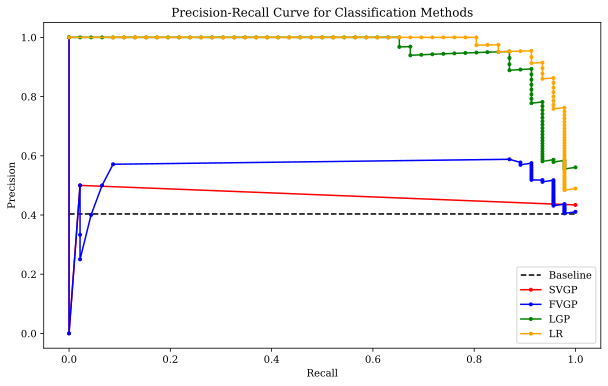

In [67]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

#Precision-Recall curves

sparse_var_prec, sparse_var_rec, thresholds = precision_recall_curve(y_test_arr, predict_sparse_var)
full_var_prec, full_var_rec, thresholds = precision_recall_curve(y_test_arr, predict_full_var)
GP_laplace_prec, GP_laplace_rec, thresholds = precision_recall_curve(y_test_arr, predict_laplace)
log_r_prec, log_r_rec, thresholds = precision_recall_curve(y_test_arr, predict_log_r)

random_predict = len(y_test_arr[y_test_arr==1]) / len(y_test_arr)
plt.plot([0, 1], [random_predict, random_predict], linestyle='--', color="Black", label="Baseline")
plt.plot(sparse_var_rec, sparse_var_prec, marker=".", color="Red", label='SVGP')
plt.plot(full_var_rec, full_var_prec, marker=".", color="Blue", label='FVGP')
plt.plot(GP_laplace_rec, GP_laplace_prec, marker=".", color="Green", label='LGP')
plt.plot(log_r_rec, log_r_prec, marker=".", color="Orange", label='LR')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("Precision-Recall Curve for Classification Methods")
plt.legend(loc="best")
plt.show()


In [68]:
#AUC and F1 scores

sparse_var_F1, sparse_var_AUC = f1_score(y_test_arr, classification_sparse_var), auc(sparse_var_rec, sparse_var_prec)
full_var_F1, full_var_AUC = f1_score(y_test_arr, classification_full_var), auc(full_var_rec, full_var_prec)
GP_laplace_F1, GP_laplace_AUC = f1_score(y_test_arr, classification_laplace), auc(GP_laplace_rec, GP_laplace_prec)
log_r_F1, log_r_AUC = f1_score(y_test_arr, classification_log_r), auc(log_r_rec, log_r_prec)


AUCs = {"GP_full_var": full_var_AUC, "GP_sparse_var": sparse_var_AUC, 
       "GP_Laplace": GP_laplace_AUC, "Logistic regression": log_r_AUC}
AUCs = pd.Series(AUCs)
F1s = {"GP_full_var": full_var_F1, "GP_sparse_var": sparse_var_F1, 
       "GP_Laplace": GP_laplace_F1, "Logistic regression": log_r_F1}
F1s = pd.Series(AUCs)

scores = pd.DataFrame({"AUC": AUCs, "F1": F1s})
scores

,AUC,F1
GP_full_var,0.553591,0.553591
GP_sparse_var,0.462264,0.462264
GP_Laplace,0.951566,0.951566
Logistic regression,0.974567,0.974567
